In [ ]:
!pip install simpleITk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 8.7 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk
import numpy as np
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
VALID_SEG_PATH = "/content/drive/MyDrive/Task_1/nnUNet_Prediction_Results"
VALID_SEG_PATH_2 = "/content/drive/MyDrive/Task_2/nnUNet_Prediction_Results"
VALID_GT_PATH  = "/content/drive/MyDrive/labelsTs"

# Evaluation Metics



In [ ]:
def compute_dice_score(groundtruth_image, segmented_image):
    """
    Compute the Dice score for each label in the images and return them in a dictionary.
    """
    labels = [0, 1, 2, 3]  # Labels for Background, CSF, GM, and WM
    scores = {}

    for label in labels:
        gt = groundtruth_image == label
        seg = segmented_image == label

        intersection = np.sum(gt & seg)
        size_gt = np.sum(gt)
        size_seg = np.sum(seg)

        if size_gt + size_seg == 0:
            scores[label] = 1
        else:
            scores[label] = 2.0 * intersection / (size_gt + size_seg)

    return scores


def compute_hausdorff_distance(ground_truth, segmentation):
    """
    Calculate the Hausdorff Distance for each label in 3D binary images, including the background.

    Parameters:
    ground_truth (np.ndarray): Ground truth 3D binary image.
    segmentation (np.ndarray): Segmented 3D binary image.

    Returns:
    dict: Hausdorff Distances for each label.
    """
    labels = np.unique(ground_truth)  # Include all labels, including background
    distances = {}

    for label in labels:
        max_hd = 0
        for slice_idx in range(ground_truth.shape[0]):
            seg1_slice = (ground_truth[slice_idx] == label).astype(int)
            seg2_slice = (segmentation[slice_idx] == label).astype(int)

            if np.any(seg1_slice) and np.any(seg2_slice):  # Proceed if label is present in the slice
                hd1 = directed_hausdorff(seg1_slice, seg2_slice)[0]
                hd2 = directed_hausdorff(seg2_slice, seg1_slice)[0]
                max_hd = max(max_hd, max(hd1, hd2))

        distances[f'Label_{label}'] = max_hd

    return distances



def compute_volumetric_difference(groundtruth_image, segmented_image):
    groundtruth_image = np.array(groundtruth_image)
    segmented_image   = np.array(segmented_image)

    if groundtruth_image.shape != segmented_image.shape:
        raise ValueError("Segmented and ground truth images must have the same shape")

    avd_scores = {}
    for label in [0, 1, 2, 3]:  # Labels for Background, CSF, GM, WM
        segmented_volume = np.sum(segmented_image == label)
        groundtruth_volume = np.sum(groundtruth_image == label)

        if groundtruth_volume > 0:
            avd_score = abs(segmented_volume - groundtruth_volume) / groundtruth_volume * 100
        else:
            avd_score = 0

        avd_scores[label] = avd_score

    return avd_scores

# 2D nnU-Net

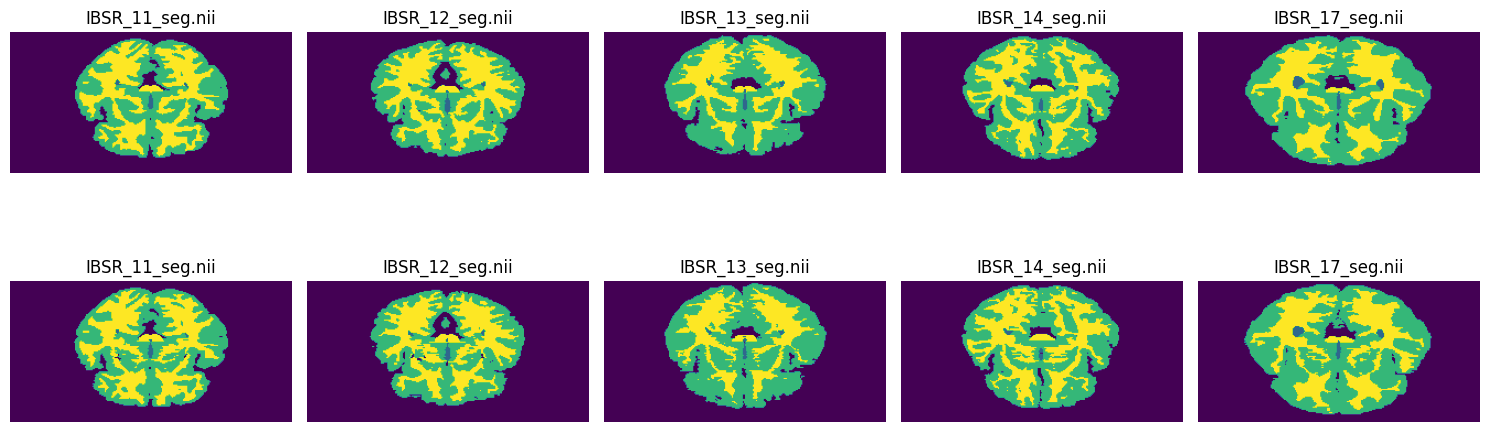

In [ ]:
# Function to read .nii.gz files and return image data using SimpleITK
def read_nii_files_from_folder(folder_path):
    nii_files = glob.glob(f"{folder_path}/*_seg.nii.gz")  # Filter files based on "*_seg.nii.gz" pattern
    nii_files.sort()  # Sort files based on filenames
    images = []
    for file in nii_files:
        img = sitk.ReadImage(file)
        data = sitk.GetArrayFromImage(img)
        images.append(data)
    return images, nii_files  # Return images and corresponding file names

# Read .nii.gz files and get image data from VALID_SEG_PATH
valid_seg_images, seg_filenames = read_nii_files_from_folder(VALID_SEG_PATH)

# Read .nii.gz files and get image data from VALID_GT_PATH
valid_gt_images, gt_filenames = read_nii_files_from_folder(VALID_GT_PATH)

# Slice number to visualize
slice_number = 125

# Create a figure and axis for subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Plot segmented images in the first row
for i in range(len(valid_seg_images)):
    axs[0, i].imshow(valid_seg_images[i][slice_number, :, :], cmap='viridis')
    axs[0, i].set_title(os.path.splitext(os.path.basename(seg_filenames[i]))[0])  # Use original filename as plot label
    axs[0, i].axis('off')

# Plot corresponding ground truth images in the second row
for i in range(len(valid_gt_images)):
    axs[1, i].imshow(valid_gt_images[i][slice_number, :, :], cmap='viridis')
    axs[1, i].set_title(os.path.splitext(os.path.basename(gt_filenames[i]))[0])  # Use original filename as plot label
    axs[1, i].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Assuming you have already defined the compute_dice_score function

dice_score_list = []

# Define labels explicitly
labels = [0, 1, 2, 3]

for i in range(len(valid_gt_images)):
    ground_truth_image = valid_gt_images[i]
    segmented_image = valid_seg_images[i]

    dice_scores = compute_dice_score(ground_truth_image, segmented_image)

    # Convert the dictionary to a list using the specified label order
    dice_scores_list = [dice_scores[label] for label in labels]

    dice_score_list.append(dice_scores_list)

# Create a DataFrame
df_dice_scores = pd.DataFrame(dice_score_list, columns=['Background', 'CSF', 'GM', 'WM'])

# Add an 'ImageID' column with the corresponding image names
df_dice_scores['ImageID'] = [os.path.splitext(os.path.basename(gt_filenames[i]))[0] for i in range(len(valid_gt_images))]

# Set 'ImageID' as the index
df_dice_scores.set_index('ImageID', inplace=True)

# Print Dice Scores DataFrame
print("Dice Scores:")
print(df_dice_scores)

# Calculate mean and standard deviation for each label
mean_dice = df_dice_scores.mean()
std_dice = df_dice_scores.std()

# Calculate overall average of mean and standard deviation
mean_avg = mean_dice.mean()
std_avg = std_dice.mean()

# Print mean and standard deviation
print("\nMean (DSC):")
print(mean_dice)

print("\nStandard Deviation (DSC):")
print(std_dice)

print("\nAverage of Mean (DSC):", mean_avg)
print("Average of Std. Dev. (DSC):", std_avg)

Dice Scores:
                 Background       CSF        GM        WM
ImageID                                                  
IBSR_11_seg.nii    0.998279  0.903007  0.947369  0.956515
IBSR_12_seg.nii    0.997679  0.901485  0.943221  0.948788
IBSR_13_seg.nii    0.996950  0.902907  0.939312  0.926240
IBSR_14_seg.nii    0.998288  0.923508  0.960472  0.958321
IBSR_17_seg.nii    0.996436  0.941121  0.949622  0.939415

Mean (DSC):
Background    0.997527
CSF           0.914406
GM            0.947999
WM            0.945856
dtype: float64

Standard Deviation (DSC):
Background    0.000820
CSF           0.017505
GM            0.008014
WM            0.013265
dtype: float64

Average of Mean (DSC): 0.9514467609559802
Average of Std. Dev. (DSC): 0.009901120051103714


In [ ]:
from scipy.spatial.distance import directed_hausdorff

# Assuming you have already defined the compute_hausdorff_distance function

hausdorff_score_list = []

# Define labels explicitly
labels = np.unique(valid_gt_images[0])  # Assuming labels are the same for all images

# Define mapping from original labels to desired labels
label_mapping = {label: name for label, name in zip(labels, ['Background', 'CSF', 'GM', 'WM'])}

for i in range(len(valid_gt_images)):
    ground_truth_image = valid_gt_images[i]
    segmented_image = valid_seg_images[i]

    hausdorff_distances = compute_hausdorff_distance(ground_truth_image, segmented_image)

    # Convert the dictionary to a list using the specified label order
    hausdorff_distances_list = [hausdorff_distances[f'Label_{label}'] for label in labels]

    hausdorff_score_list.append(hausdorff_distances_list)

# Create a DataFrame
df_hausdorff_scores = pd.DataFrame(hausdorff_score_list, columns=[label_mapping[label] for label in labels])

# Add an 'ImageID' column with the corresponding image names
df_hausdorff_scores['ImageID'] = [os.path.splitext(os.path.basename(gt_filenames[i]))[0] for i in range(len(valid_gt_images))]

# Set 'ImageID' as the index
df_hausdorff_scores.set_index('ImageID', inplace=True)

# Print Hausdorff Distances DataFrame
print("Hausdorff Distances:")
print(df_hausdorff_scores)

# Calculate mean and standard deviation for each label
mean_hd = df_hausdorff_scores.mean()
std_hd = df_hausdorff_scores.std()

# Calculate overall average of mean and standard deviation
mean_avg = mean_hd.mean()
std_avg = std_hd.mean()

# Print mean and standard deviation
print("\nMean (Hausdorff):")
print(mean_hd)

print("\nStandard Deviation (Hausdorff):")
print(std_hd)

print("\nAverage of Mean (Hausdorff):", mean_avg)
print("Average of Std. Dev. (Hausdorff):", std_avg)


Hausdorff Distances:
                 Background       CSF        GM        WM
ImageID                                                  
IBSR_11_seg.nii    5.196152  3.162278  6.164414  6.000000
IBSR_12_seg.nii    5.291503  4.000000  6.082763  5.567764
IBSR_13_seg.nii    6.633250  3.162278  6.403124  5.567764
IBSR_14_seg.nii    4.898979  2.645751  5.916080  5.099020
IBSR_17_seg.nii    5.744563  3.162278  6.403124  5.744563

Mean (Hausdorff):
Background    5.552889
CSF           3.226517
GM            6.193901
WM            5.595822
dtype: float64

Standard Deviation (Hausdorff):
Background    0.675851
CSF           0.486812
GM            0.210923
WM            0.329344
dtype: float64

Average of Mean (Hausdorff): 5.1422823363122045
Average of Std. Dev. (Hausdorff): 0.42573278534496795


In [ ]:
avd_score_list = []

# Define labels explicitly
labels = [0, 1, 2, 3]

for i in range(len(valid_gt_images)):
    ground_truth_image = valid_gt_images[i]
    segmented_image = valid_seg_images[i]

    avd_scores = compute_volumetric_difference(ground_truth_image, segmented_image)

    # Convert the dictionary to a list using the specified label order
    avd_scores_list = [avd_scores[label] for label in labels]

    avd_score_list.append(avd_scores_list)

# Create a DataFrame
df_avd_scores = pd.DataFrame(avd_score_list, columns=['Background', 'CSF', 'GM', 'WM'])

# Add an 'ImageID' column with the corresponding image names
df_avd_scores['ImageID'] = [os.path.splitext(os.path.basename(gt_filenames[i]))[0] for i in range(len(valid_gt_images))]

# Set 'ImageID' as the index
df_avd_scores.set_index('ImageID', inplace=True)

# Print Volumetric Differences DataFrame
print("Volumetric Differences:")
print(df_avd_scores)

# Calculate mean and standard deviation for each label
mean_avd = df_avd_scores.mean()
std_avd = df_avd_scores.std()

# Calculate overall average of mean and standard deviation
mean_avg = mean_avd.mean()
std_avg = std_avd.mean()

# Print mean and standard deviation
print("\nMean (AVD):")
print(mean_avd)

print("\nStandard Deviation (AVD):")
print(std_avd)

print("\nAverage of Mean (AVD):", mean_avg)
print("Average of Std. Dev. (AVD):", std_avg)

Volumetric Differences:
                 Background        CSF        GM        WM
ImageID                                                   
IBSR_11_seg.nii    0.145760   2.783208  2.282327  0.211629
IBSR_12_seg.nii    0.004663   9.049535  1.461121  3.213582
IBSR_13_seg.nii    0.395717   1.194895  6.143286  5.472162
IBSR_14_seg.nii    0.033818  10.987663  0.124219  0.845613
IBSR_17_seg.nii    0.420614   6.080972  0.830025  4.748637

Mean (AVD):
Background    0.200115
CSF           6.019255
GM            2.168196
WM            2.898325
dtype: float64

Standard Deviation (AVD):
Background    0.197288
CSF           4.111506
GM            2.360236
WM            2.322695
dtype: float64

Average of Mean (AVD): 2.821472430815409
Average of Std. Dev. (AVD): 2.247931388334502


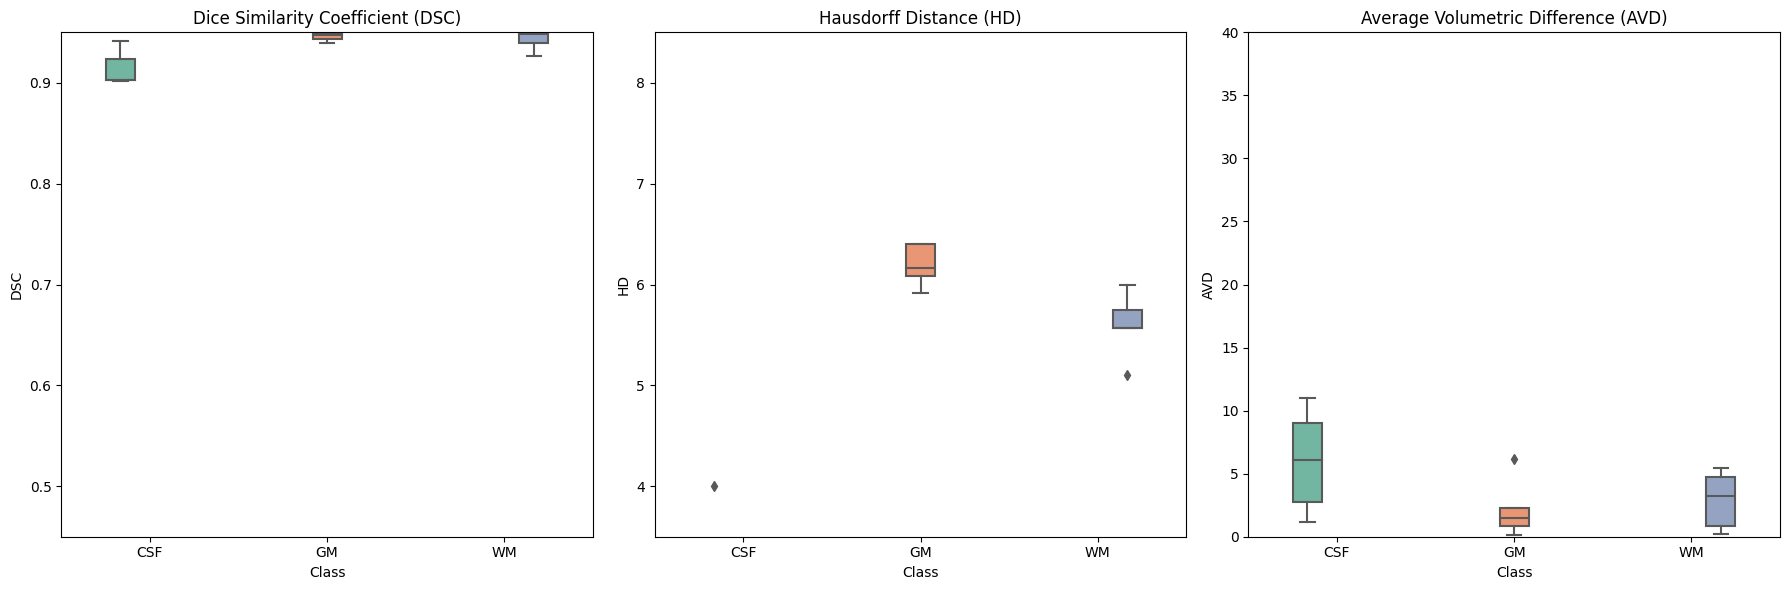

In [ ]:
import seaborn as sns

# Reshape the data into a long format
df_dice_long = df_dice_scores.melt(var_name='Class', value_name='DSC')
df_hd_long   = df_hausdorff_scores.melt(var_name='Class', value_name='HD')
df_avd_long  = df_avd_scores.melt(var_name='Class', value_name='AVD')

# Combine the data into a single DataFrame
combined_data = pd.concat([df_dice_long, df_hd_long, df_avd_long], keys=['DSC', 'HD', 'AVD'])

# Correcting the DataFrame structure for combined data
combined_data = combined_data.reset_index(level=0).reset_index(drop=True)
combined_data.rename(columns={'level_0': 'Metric'}, inplace=True)

# Remove the 'Background' class from the DataFrame
combined_data = combined_data[combined_data['Class'] != 'Background']

# Number of unique classes
num_classes = combined_data['Class'].nunique()

# Define a color palette with the exact number of unique classes
palette = sns.color_palette("Set2", n_colors=num_classes)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# DSC Plot
sns.boxplot(ax=axes[0], x='Class', y='DSC', hue='Class', data=combined_data[combined_data['Metric'] == 'DSC'], width=0.5, palette=palette)
axes[0].set_title('Dice Similarity Coefficient (DSC)')
axes[0].set_ylim([0.45, 1])

# HD Plot
sns.boxplot(ax=axes[1], x='Class', y='HD', hue='Class', data=combined_data[combined_data['Metric'] == 'HD'], width=0.5, palette=palette)
axes[1].set_title('Hausdorff Distance (HD)')
axes[1].set_ylim([0, 8.5])

# AVD Plot
sns.boxplot(ax=axes[2], x='Class', y='AVD', hue='Class', data=combined_data[combined_data['Metric'] == 'AVD'], width=0.5, palette=palette)
axes[2].set_title('Average Volumetric Difference (AVD)')
axes[2].set_ylim([0, 40])

# Remove the legends
for ax in axes:
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

# 3D nnU-Net

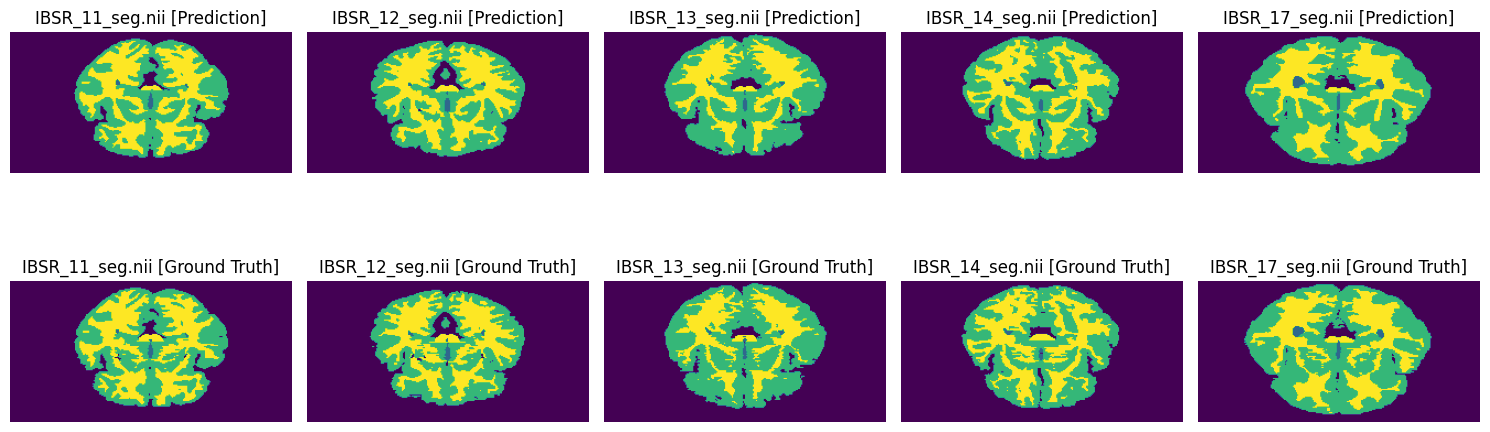

In [ ]:
# Function to read .nii.gz files and return image data using SimpleITK
def read_nii_files_from_folder(folder_path):
    nii_files = glob.glob(f"{folder_path}/*_seg.nii.gz")  # Filter files based on "*_seg.nii.gz" pattern
    nii_files.sort()  # Sort files based on filenames
    images = []
    for file in nii_files:
        img = sitk.ReadImage(file)
        data = sitk.GetArrayFromImage(img)
        images.append(data)
    return images, nii_files  # Return images and corresponding file names

# Read .nii.gz files and get image data from VALID_SEG_PATH
valid_seg_images, seg_filenames = read_nii_files_from_folder(VALID_SEG_PATH_2)

# Read .nii.gz files and get image data from VALID_GT_PATH
valid_gt_images, gt_filenames = read_nii_files_from_folder(VALID_GT_PATH)

# Slice number to visualize
slice_number = 125

# Create a figure and axis for subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Plot segmented images in the first row
for i in range(len(valid_seg_images)):
    axs[0, i].imshow(valid_seg_images[i][slice_number, :, :], cmap='viridis')
    axs[0, i].set_title(os.path.splitext(os.path.basename(seg_filenames[i]))[0] + ' [Prediction]')  # Use original filename as plot label
    axs[0, i].axis('off')

# Plot corresponding ground truth images in the second row
for i in range(len(valid_gt_images)):
    axs[1, i].imshow(valid_gt_images[i][slice_number, :, :], cmap='viridis')
    axs[1, i].set_title(os.path.splitext(os.path.basename(gt_filenames[i]))[0] + ' [Ground Truth]')  # Use original filename as plot label
    axs[1, i].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Assuming you have already defined the compute_dice_score function

dice_score_list = []

# Define labels explicitly
labels = [0, 1, 2, 3]

for i in range(len(valid_gt_images)):
    ground_truth_image = valid_gt_images[i]
    segmented_image = valid_seg_images[i]

    dice_scores = compute_dice_score(ground_truth_image, segmented_image)

    # Convert the dictionary to a list using the specified label order
    dice_scores_list = [dice_scores[label] for label in labels]

    dice_score_list.append(dice_scores_list)

# Create a DataFrame
df_dice_scores = pd.DataFrame(dice_score_list, columns=['Background', 'CSF', 'GM', 'WM'])

# Add an 'ImageID' column with the corresponding image names
df_dice_scores['ImageID'] = [os.path.splitext(os.path.basename(gt_filenames[i]))[0] for i in range(len(valid_gt_images))]

# Set 'ImageID' as the index
df_dice_scores.set_index('ImageID', inplace=True)

# Print Dice Scores DataFrame
print("Dice Scores:")
print(df_dice_scores)

# Calculate mean and standard deviation for each label
mean_dice = df_dice_scores.mean()
std_dice = df_dice_scores.std()

# Calculate overall average of mean and standard deviation
mean_avg = mean_dice.mean()
std_avg = std_dice.mean()

# Print mean and standard deviation
print("\nMean (DSC):")
print(mean_dice)

print("\nStandard Deviation (DSC):")
print(std_dice)

print("\nAverage of Mean (DSC):", mean_avg)
print("Average of Std. Dev. (DSC):", std_avg)

Dice Scores:
                 Background       CSF        GM        WM
ImageID                                                  
IBSR_11_seg.nii    0.998296  0.909141  0.947011  0.955042
IBSR_12_seg.nii    0.997941  0.905704  0.943308  0.943200
IBSR_13_seg.nii    0.997188  0.908183  0.941158  0.925369
IBSR_14_seg.nii    0.998395  0.933504  0.960320  0.954818
IBSR_17_seg.nii    0.996453  0.946748  0.950155  0.940685

Mean (DSC):
Background    0.997655
CSF           0.920656
GM            0.948390
WM            0.943823
dtype: float64

Standard Deviation (DSC):
Background    0.000822
CSF           0.018423
GM            0.007508
WM            0.012222
dtype: float64

Average of Mean (DSC): 0.9526309687208194
Average of Std. Dev. (DSC): 0.009743709722313048


In [ ]:
from scipy.spatial.distance import directed_hausdorff

# Assuming you have already defined the compute_hausdorff_distance function

hausdorff_score_list = []

# Define labels explicitly
labels = np.unique(valid_gt_images[0])  # Assuming labels are the same for all images

# Define mapping from original labels to desired labels
label_mapping = {label: name for label, name in zip(labels, ['Background', 'CSF', 'GM', 'WM'])}

for i in range(len(valid_gt_images)):
    ground_truth_image = valid_gt_images[i]
    segmented_image = valid_seg_images[i]

    hausdorff_distances = compute_hausdorff_distance(ground_truth_image, segmented_image)

    # Convert the dictionary to a list using the specified label order
    hausdorff_distances_list = [hausdorff_distances[f'Label_{label}'] for label in labels]

    hausdorff_score_list.append(hausdorff_distances_list)

# Create a DataFrame
df_hausdorff_scores = pd.DataFrame(hausdorff_score_list, columns=[label_mapping[label] for label in labels])

# Add an 'ImageID' column with the corresponding image names
df_hausdorff_scores['ImageID'] = [os.path.splitext(os.path.basename(gt_filenames[i]))[0] for i in range(len(valid_gt_images))]

# Set 'ImageID' as the index
df_hausdorff_scores.set_index('ImageID', inplace=True)

# Print Hausdorff Distances DataFrame
print("Hausdorff Distances:")
print(df_hausdorff_scores)

# Calculate mean and standard deviation for each label
mean_hd = df_hausdorff_scores.mean()
std_hd = df_hausdorff_scores.std()

# Calculate overall average of mean and standard deviation
mean_avg = mean_hd.mean()
std_avg = std_hd.mean()

# Print mean and standard deviation
print("\nMean (Hausdorff):")
print(mean_hd)

print("\nStandard Deviation (Hausdorff):")
print(std_hd)

print("\nAverage of Mean (Hausdorff):", mean_avg)
print("Average of Std. Dev. (Hausdorff):", std_avg)

Hausdorff Distances:
                 Background       CSF        GM        WM
ImageID                                                  
IBSR_11_seg.nii    5.099020  3.316625  6.244998  6.000000
IBSR_12_seg.nii    5.099020  3.872983  5.830952  5.477226
IBSR_13_seg.nii    6.633250  3.162278  6.403124  5.477226
IBSR_14_seg.nii    4.795832  2.645751  6.082763  5.385165
IBSR_17_seg.nii    5.916080  3.000000  6.403124  6.244998

Mean (Hausdorff):
Background    5.508640
CSF           3.199527
GM            6.192992
WM            5.716923
dtype: float64

Standard Deviation (Hausdorff):
Background    0.754060
CSF           0.451420
GM            0.241991
WM            0.382089
dtype: float64

Average of Mean (Hausdorff): 5.154520593807417
Average of Std. Dev. (Hausdorff): 0.4573903405585441


In [ ]:
avd_score_list = []

# Define labels explicitly
labels = [0, 1, 2, 3]

for i in range(len(valid_gt_images)):
    ground_truth_image = valid_gt_images[i]
    segmented_image = valid_seg_images[i]

    avd_scores = compute_volumetric_difference(ground_truth_image, segmented_image)

    # Convert the dictionary to a list using the specified label order
    avd_scores_list = [avd_scores[label] for label in labels]

    avd_score_list.append(avd_scores_list)

# Create a DataFrame
df_avd_scores = pd.DataFrame(avd_score_list, columns=['Background', 'CSF', 'GM', 'WM'])

# Add an 'ImageID' column with the corresponding image names
df_avd_scores['ImageID'] = [os.path.splitext(os.path.basename(gt_filenames[i]))[0] for i in range(len(valid_gt_images))]

# Set 'ImageID' as the index
df_avd_scores.set_index('ImageID', inplace=True)

# Print Volumetric Differences DataFrame
print("Volumetric Differences:")
print(df_avd_scores)

# Calculate mean and standard deviation for each label
mean_avd = df_avd_scores.mean()
std_avd = df_avd_scores.std()

# Calculate overall average of mean and standard deviation
mean_avg = mean_avd.mean()
std_avg = std_avd.mean()

# Print mean and standard deviation
print("\nMean (AVD):")
print(mean_avd)

print("\nStandard Deviation (AVD):")
print(std_avd)

print("\nAverage of Mean (AVD):", mean_avg)
print("Average of Std. Dev. (AVD):", std_avg)

Volumetric Differences:
                 Background        CSF        GM        WM
ImageID                                                   
IBSR_11_seg.nii    0.148094   2.029228  1.221661  1.385746
IBSR_12_seg.nii    0.023063  11.628521  2.901880  6.896227
IBSR_13_seg.nii    0.369366   4.299810  6.423923  7.095153
IBSR_14_seg.nii    0.104588   8.635741  0.481189  3.289847
IBSR_17_seg.nii    0.436196   2.237605  1.006004  4.390623

Mean (AVD):
Background    0.216261
CSF           5.766181
GM            2.406931
WM            4.611519
dtype: float64

Standard Deviation (AVD):
Background    0.177662
CSF           4.218036
GM            2.421629
WM            2.428454
dtype: float64

Average of Mean (AVD): 3.2502231600737996
Average of Std. Dev. (AVD): 2.311445239670995


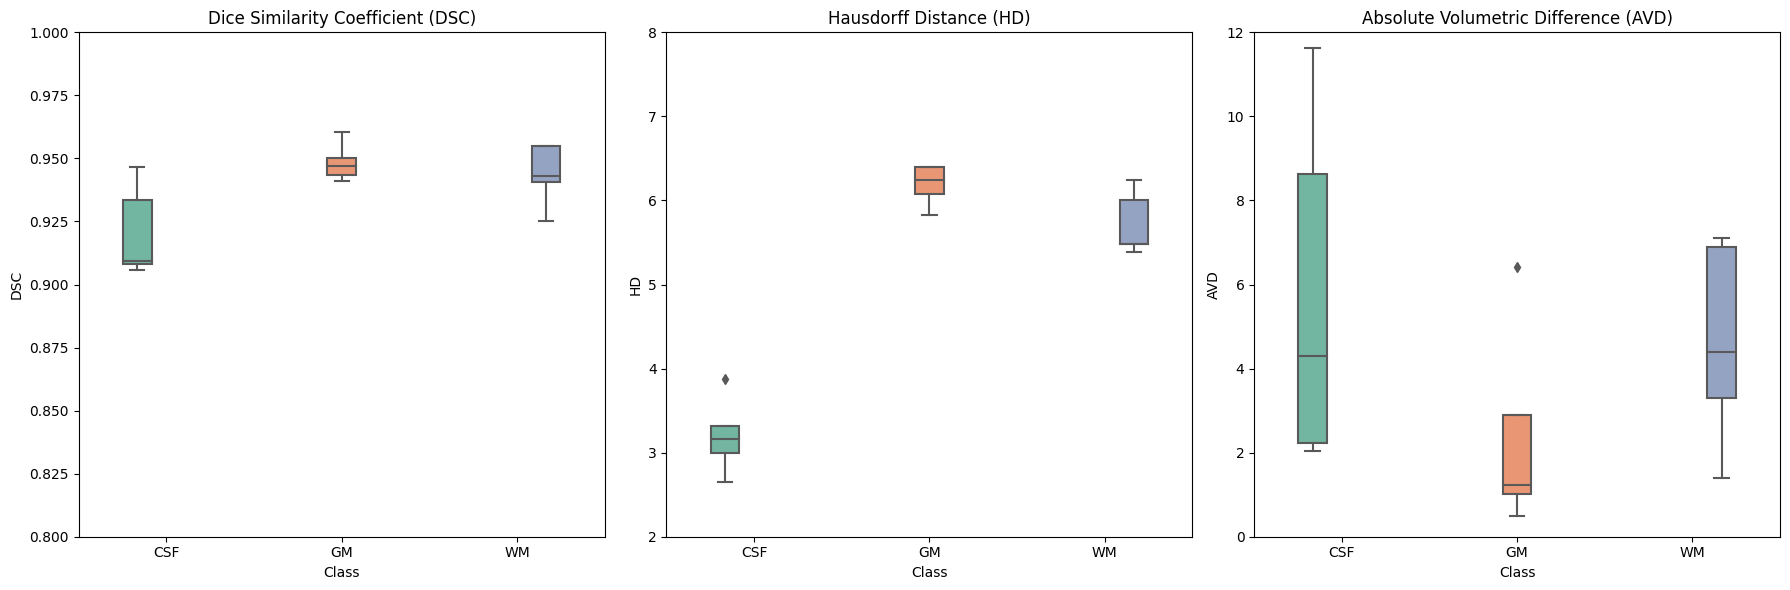

In [ ]:
import seaborn as sns

# Reshape the data into a long format
df_dice_long = df_dice_scores.melt(var_name='Class', value_name='DSC')
df_hd_long   = df_hausdorff_scores.melt(var_name='Class', value_name='HD')
df_avd_long  = df_avd_scores.melt(var_name='Class', value_name='AVD')

# Combine the data into a single DataFrame
combined_data = pd.concat([df_dice_long, df_hd_long, df_avd_long], keys=['DSC', 'HD', 'AVD'])

# Correcting the DataFrame structure for combined data
combined_data = combined_data.reset_index(level=0).reset_index(drop=True)
combined_data.rename(columns={'level_0': 'Metric'}, inplace=True)

# Remove the 'Background' class from the DataFrame
combined_data = combined_data[combined_data['Class'] != 'Background']

# Number of unique classes
num_classes = combined_data['Class'].nunique()

# Define a color palette with the exact number of unique classes
palette = sns.color_palette("Set2", n_colors=num_classes)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# DSC Plot
sns.boxplot(ax=axes[0], x='Class', y='DSC', hue='Class', data=combined_data[combined_data['Metric'] == 'DSC'], width=0.5, palette=palette)
axes[0].set_title('Dice Similarity Coefficient (DSC)')
axes[0].set_ylim([0.8, 1])

# HD Plot
sns.boxplot(ax=axes[1], x='Class', y='HD', hue='Class', data=combined_data[combined_data['Metric'] == 'HD'], width=0.5, palette=palette)
axes[1].set_title('Hausdorff Distance (HD)')
axes[1].set_ylim([2, 8])

# AVD Plot
sns.boxplot(ax=axes[2], x='Class', y='AVD', hue='Class', data=combined_data[combined_data['Metric'] == 'AVD'], width=0.5, palette=palette)
axes[2].set_title('Absolute Volumetric Difference (AVD)')
axes[2].set_ylim([0, 12])

# Remove the legends
for ax in axes:
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()